# Toxicity Analysis — Philippine Airlines Reddit Data

## Overview

This notebook applies our trained **5-class toxicity classifier** to analyze Reddit discussions about Philippine airlines (Cebu Pacific and Philippine Airlines).

### Pipeline

```
CSV Data → Load & Clean → Combine Text Fields → Batch Inference → Analytics → Export
```

### Data Sources

| Dataset | Source | Description |
|---------|--------|-------------|
| `cebupac_data.csv` | r/CebuPacificAir | Reddit posts/comments about Cebu Pacific |
| `phairlines_data.csv` | r/philippineairlines | Reddit posts/comments about PAL |

### Toxicity Classes

| Class | Label | Description |
|-------|-------|-------------|
| 1 | `NON_TOXIC` | Neutral, harmless content |
| 2 | `MILD` | Slightly problematic |
| 3 | `MODERATE` | Moderately toxic |
| 4 | `TOXIC` | Clearly harmful |
| 5 | `SEVERE` | Hate speech / severe toxicity |

<br>

---

## Step 0 — Environment Setup

In [1]:
# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================

import os
import re
import json
import warnings
from typing import List, Dict, Union, Optional
from dataclasses import dataclass, asdict
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import joblib
from tqdm.auto import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"{'='*60}")
print(f"TOXICITY ANALYSIS — AIRLINE REDDIT DATA")
print(f"{'='*60}")
print(f"\n[OK] Environment ready.")
print(f"     Device: {DEVICE}")
print(f"     PyTorch: {torch.__version__}")
print(f"     Pandas: {pd.__version__}")

TOXICITY ANALYSIS — AIRLINE REDDIT DATA

[OK] Environment ready.
     Device: cuda
     PyTorch: 2.6.0+cu124
     Pandas: 2.3.2


<br>

---

## Step 1 — Configuration

Set paths to your data and model artifacts.

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# ---------------------------------
# Data Paths (UPDATE THESE)
# ---------------------------------
DATA_DIR = r"C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset"

DATASETS = {
    "cebu_pacific": {
        "path": os.path.join(DATA_DIR, "cebupac_data.csv"),
        "name": "Cebu Pacific",
        "subreddit": "r/CebuPacificAir"
    },
    "philippine_airlines": {
        "path": os.path.join(DATA_DIR, "phairlines_data.csv"),
        "name": "Philippine Airlines",
        "subreddit": "r/philippineairlines"
    }
}

# ---------------------------------
# Model Artifacts Path
# ---------------------------------
ARTIFACT_DIR = "./toxicity_model_artifacts"

# ---------------------------------
# Output Configuration
# ---------------------------------
OUTPUT_DIR = "./toxicity_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------
# Processing Configuration
# ---------------------------------
BATCH_SIZE = 32  # Adjust based on GPU memory
MAX_SEQ_LENGTH = 256

print(f"\n📁 Data Directory: {DATA_DIR}")
print(f"📁 Artifact Directory: {ARTIFACT_DIR}")
print(f"📁 Output Directory: {OUTPUT_DIR}")
print(f"\n⚙️  Batch Size: {BATCH_SIZE}")
print(f"⚙️  Max Sequence Length: {MAX_SEQ_LENGTH}")


📁 Data Directory: C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset
📁 Artifact Directory: ./toxicity_model_artifacts
📁 Output Directory: ./toxicity_results

⚙️  Batch Size: 32
⚙️  Max Sequence Length: 256


<br>

---

## Step 2 — Load Model Artifacts

In [3]:
# ============================================================================
# LOAD MODEL ARTIFACTS
# ============================================================================

print(f"\n{'='*60}")
print("LOADING MODEL ARTIFACTS")
print(f"{'='*60}")

# ---------------------------------
# 2.1 Load Configuration
# ---------------------------------
config_path = os.path.join(ARTIFACT_DIR, "config.json")
with open(config_path, "r") as f:
    config = json.load(f)

MODEL_NAME = config["model_name"]
NUM_CLASSES = config["num_classes"]

print(f"\n[1] Config loaded:")
print(f"    Model: {MODEL_NAME}")
print(f"    Classes: {NUM_CLASSES}")

# ---------------------------------
# 2.2 Load Scaler
# ---------------------------------
scaler_path = os.path.join(ARTIFACT_DIR, "scaler.joblib")
scaler = joblib.load(scaler_path)
print(f"[2] Scaler loaded")

# ---------------------------------
# 2.3 Load Classifier
# ---------------------------------
classifier_path = os.path.join(ARTIFACT_DIR, "classifier.joblib")
classifier = joblib.load(classifier_path)
print(f"[3] Classifier loaded")

# ---------------------------------
# 2.4 Load DeBERTa Model
# ---------------------------------
print(f"[4] Loading DeBERTa from HuggingFace...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
embedding_model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
embedding_model.eval()
print(f"    DeBERTa loaded successfully.")

print(f"\n{'='*60}")
print("✅ All artifacts loaded. Ready for inference.")
print(f"{'='*60}")


LOADING MODEL ARTIFACTS

[1] Config loaded:
    Model: sileod/deberta-v3-base-tasksource-toxicity
    Classes: 5
[2] Scaler loaded
[3] Classifier loaded
[4] Loading DeBERTa from HuggingFace...
    DeBERTa loaded successfully.

✅ All artifacts loaded. Ready for inference.


<br>

---

## Step 3 — Define Toxicity Classifier

Enhanced classifier with:
- Progress bar for batch processing
- Graceful handling of empty/missing text
- Memory-efficient batching

In [4]:
# ============================================================================
# TOXICITY CLASSIFIER CLASS
# ============================================================================

@dataclass
class ToxicityPrediction:
    """
    Container for a single toxicity prediction.
    """
    text: str
    label: int
    label_name: str
    confidence: float
    prob_class_1: float
    prob_class_2: float
    prob_class_3: float
    prob_class_4: float
    prob_class_5: float


class ToxicityClassifier:
    """
    End-to-end toxicity classification pipeline optimized for batch processing.
    """
    
    LABEL_NAMES = {
        1: "NON_TOXIC",
        2: "MILD",
        3: "MODERATE",
        4: "TOXIC",
        5: "SEVERE"
    }
    
    LABEL_COLORS = {
        "NON_TOXIC": "#2ecc71",   # Green
        "MILD": "#f1c40f",         # Yellow
        "MODERATE": "#e67e22",     # Orange
        "TOXIC": "#e74c3c",        # Red
        "SEVERE": "#8e44ad"        # Purple
    }
    
    def __init__(
        self,
        tokenizer,
        embedding_model,
        scaler,
        classifier,
        max_length: int = 256,
        device: str = "cpu"
    ):
        self.tokenizer = tokenizer
        self.embedding_model = embedding_model
        self.scaler = scaler
        self.classifier = classifier
        self.max_length = max_length
        self.device = device
        self.embedding_model.eval()
    
    def _normalize_text(self, text: str) -> str:
        """
        Apply minimal text normalization.
        Handles None, NaN, and non-string inputs gracefully.
        """
        if text is None or (isinstance(text, float) and np.isnan(text)):
            return ""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = re.sub(r"\s+", " ", text).strip()
        return text
    
    def _get_embeddings_batch(self, texts: List[str]) -> np.ndarray:
        """
        Extract DeBERTa embeddings for a single batch.
        """
        # Handle empty texts
        texts = [t if t else "[empty]" for t in texts]
        
        encoded = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.embedding_model(**encoded)
            hidden_states = outputs.last_hidden_state
            embeddings = hidden_states.mean(dim=1)
        
        return embeddings.cpu().numpy()
    
    def predict_dataframe(
        self,
        texts: List[str],
        batch_size: int = 32,
        show_progress: bool = True
    ) -> pd.DataFrame:
        """
        Predict toxicity for a list of texts and return as DataFrame.
        
        Args:
            texts: List of input strings
            batch_size: Number of texts per batch
            show_progress: Show progress bar
        
        Returns:
            DataFrame with predictions and probabilities
        """
        # Normalize all texts
        normalized = [self._normalize_text(t) for t in texts]
        
        # Process in batches
        all_embeddings = []
        n_batches = (len(normalized) + batch_size - 1) // batch_size
        
        iterator = range(0, len(normalized), batch_size)
        if show_progress:
            iterator = tqdm(iterator, total=n_batches, desc="Extracting embeddings")
        
        for i in iterator:
            batch = normalized[i:i + batch_size]
            embeddings = self._get_embeddings_batch(batch)
            all_embeddings.append(embeddings)
        
        # Combine embeddings
        all_embeddings = np.vstack(all_embeddings)
        
        # Scale embeddings
        if show_progress:
            print("Scaling embeddings...")
        scaled = self.scaler.transform(all_embeddings)
        
        # Classify
        if show_progress:
            print("Classifying...")
        predictions = self.classifier.predict(scaled)
        probabilities = self.classifier.predict_proba(scaled)
        
        # Build results DataFrame
        results = pd.DataFrame({
            "text_original": texts,
            "text_normalized": normalized,
            "toxicity_label": predictions,
            "toxicity_name": [self.LABEL_NAMES[p] for p in predictions],
            "confidence": [probabilities[i, p-1] for i, p in enumerate(predictions)],
            "prob_NON_TOXIC": probabilities[:, 0],
            "prob_MILD": probabilities[:, 1],
            "prob_MODERATE": probabilities[:, 2],
            "prob_TOXIC": probabilities[:, 3],
            "prob_SEVERE": probabilities[:, 4]
        })
        
        if show_progress:
            print(f"✅ Processed {len(texts):,} texts")
        
        return results


# Instantiate the classifier
toxicity_clf = ToxicityClassifier(
    tokenizer=tokenizer,
    embedding_model=embedding_model,
    scaler=scaler,
    classifier=classifier,
    max_length=MAX_SEQ_LENGTH,
    device=DEVICE
)

print("\n✅ ToxicityClassifier instantiated and ready.")


✅ ToxicityClassifier instantiated and ready.


<br>

---

## Step 4 — Load & Prepare Reddit Data

Load the CSV files and prepare text for analysis:
- Combine `title` and `body` fields
- Handle missing values
- Filter empty texts

In [5]:
# ============================================================================
# LOAD & PREPARE REDDIT DATA
# ============================================================================

def load_reddit_data(file_path: str, dataset_name: str) -> pd.DataFrame:
    """
    Load Reddit CSV data and prepare for toxicity analysis.
    
    Args:
        file_path: Path to CSV file
        dataset_name: Name identifier for the dataset
    
    Returns:
        Prepared DataFrame
    """
    print(f"\n📂 Loading: {file_path}")
    
    # Load CSV
    df = pd.read_csv(file_path, encoding='utf-8')
    print(f"   Raw rows: {len(df):,}")
    print(f"   Columns: {list(df.columns)}")
    
    # Add dataset identifier
    df["dataset"] = dataset_name
    
    # Combine title and body for analysis
    # Posts have title, comments have body
    def combine_text(row):
        title = row.get("title", "") or ""
        body = row.get("body", "") or ""
        
        # Handle NaN values
        if pd.isna(title):
            title = ""
        if pd.isna(body):
            body = ""
        
        # Combine non-empty parts
        parts = [str(title).strip(), str(body).strip()]
        parts = [p for p in parts if p]
        
        return " ".join(parts)
    
    df["combined_text"] = df.apply(combine_text, axis=1)
    
    # Filter out empty texts
    df = df[df["combined_text"].str.len() > 0].copy()
    print(f"   After filtering empty: {len(df):,} rows")
    
    # Parse datetime if available
    if "created_utc" in df.columns:
        try:
            df["created_datetime"] = pd.to_datetime(df["created_utc"], errors='coerce')
        except:
            pass
    
    return df


# Load all datasets
print(f"\n{'='*60}")
print("LOADING REDDIT DATASETS")
print(f"{'='*60}")

all_data = {}
for key, info in DATASETS.items():
    if os.path.exists(info["path"]):
        all_data[key] = load_reddit_data(info["path"], info["name"])
    else:
        print(f"\n⚠️  File not found: {info['path']}")

# Combine all datasets
if all_data:
    df_combined = pd.concat(all_data.values(), ignore_index=True)
    print(f"\n{'='*60}")
    print(f"📊 TOTAL: {len(df_combined):,} rows loaded")
    print(f"{'='*60}")
else:
    print("\n❌ No data loaded. Please check file paths.")


LOADING REDDIT DATASETS

📂 Loading: C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset\cebupac_data.csv
   Raw rows: 2,285
   Columns: ['post_id', 'comment_id', 'parent_id', 'level', 'level_path', 'type', 'title', 'body', 'author', 'score', 'upvote_ratio', 'num_comments', 'created_utc', 'url', 'permalink', 'is_original_content', 'is_self', 'over_18', 'spoiler', 'stickied']
   After filtering empty: 2,285 rows

📂 Loading: C:\Users\Pipoy\S390 NLP\03_finalproject\proto2\Inference_dataset\phairlines_data.csv
   Raw rows: 707
   Columns: ['post_id', 'comment_id', 'parent_id', 'level', 'level_path', 'type', 'title', 'body', 'author', 'score', 'upvote_ratio', 'num_comments', 'created_utc', 'url', 'permalink', 'is_original_content', 'is_self', 'over_18', 'spoiler', 'stickied']
   After filtering empty: 707 rows

📊 TOTAL: 2,992 rows loaded


<br>

---

## Step 5 — Preview Data

In [6]:
# ============================================================================
# PREVIEW DATA
# ============================================================================

print(f"\n{'='*60}")
print("DATA PREVIEW")
print(f"{'='*60}")

# Dataset breakdown
print("\n📊 Dataset Breakdown:")
print(df_combined["dataset"].value_counts().to_string())

# Type breakdown (post vs comment)
if "type" in df_combined.columns:
    print("\n📊 Content Type Breakdown:")
    print(df_combined["type"].value_counts().to_string())

# Sample texts
print("\n📝 Sample Combined Texts:")
print("-" * 60)
for idx, row in df_combined.head(5).iterrows():
    text = row["combined_text"][:100]
    print(f"[{row['dataset']}] {text}...")
    print()


DATA PREVIEW

📊 Dataset Breakdown:
dataset
Cebu Pacific           2285
Philippine Airlines     707

📊 Content Type Breakdown:
type
comment    2444
post        548

📝 Sample Combined Texts:
------------------------------------------------------------
[Cebu Pacific] Travel Tax not reflected in Fare Breakdown Hi, just paid the travel tax sa Ceb Pac for our flight th...

[Cebu Pacific] Mas mura to pay Travel Tax sa airport, you save the processing fee. Also pag may nangyari sa flight ...

[Cebu Pacific] Prepare mo nalang siguro yung receipt for your payment sa Travel Tax. Check-in counter staff should ...

[Cebu Pacific] How legit is this travel fund? Planning to book a flight with cebu pacific and i've seen posts that ...

[Cebu Pacific] Travel fund is legit. Your counterparty however, may not be....



<br>

---

## Step 6 — Run Toxicity Inference

Process all texts through the classifier.

In [7]:
# ============================================================================
# RUN TOXICITY INFERENCE
# ============================================================================

print(f"\n{'='*60}")
print("RUNNING TOXICITY INFERENCE")
print(f"{'='*60}")
print(f"\nProcessing {len(df_combined):,} texts...\n")

# Get predictions
start_time = datetime.now()

predictions_df = toxicity_clf.predict_dataframe(
    texts=df_combined["combined_text"].tolist(),
    batch_size=BATCH_SIZE,
    show_progress=True
)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print(f"\n⏱️  Time elapsed: {duration:.1f} seconds")
print(f"⚡ Speed: {len(df_combined) / duration:.1f} texts/second")


RUNNING TOXICITY INFERENCE

Processing 2,992 texts...



Extracting embeddings:   0%|          | 0/94 [00:00<?, ?it/s]

Scaling embeddings...
Classifying...
✅ Processed 2,992 texts

⏱️  Time elapsed: 23.6 seconds
⚡ Speed: 126.6 texts/second


In [8]:
# ============================================================================
# MERGE PREDICTIONS WITH ORIGINAL DATA
# ============================================================================

# Add predictions to original dataframe
df_results = df_combined.copy()
df_results["toxicity_label"] = predictions_df["toxicity_label"].values
df_results["toxicity_name"] = predictions_df["toxicity_name"].values
df_results["toxicity_confidence"] = predictions_df["confidence"].values
df_results["prob_NON_TOXIC"] = predictions_df["prob_NON_TOXIC"].values
df_results["prob_MILD"] = predictions_df["prob_MILD"].values
df_results["prob_MODERATE"] = predictions_df["prob_MODERATE"].values
df_results["prob_TOXIC"] = predictions_df["prob_TOXIC"].values
df_results["prob_SEVERE"] = predictions_df["prob_SEVERE"].values

print(f"\n✅ Predictions merged with original data")
print(f"   Result shape: {df_results.shape}")


✅ Predictions merged with original data
   Result shape: (2992, 31)


<br>

---

## Step 7 — Toxicity Analytics

Analyze the distribution of toxicity across datasets.

In [9]:
# ============================================================================
# OVERALL TOXICITY DISTRIBUTION
# ============================================================================

print(f"\n{'='*60}")
print("TOXICITY ANALYSIS RESULTS")
print(f"{'='*60}")

# Overall distribution
print("\n📊 Overall Toxicity Distribution:")
print("-" * 40)

toxicity_counts = df_results["toxicity_name"].value_counts()
toxicity_pcts = df_results["toxicity_name"].value_counts(normalize=True) * 100

# Order by severity
label_order = ["NON_TOXIC", "MILD", "MODERATE", "TOXIC", "SEVERE"]

for label in label_order:
    if label in toxicity_counts.index:
        count = toxicity_counts[label]
        pct = toxicity_pcts[label]
        bar = "█" * int(pct / 2)
        print(f"{label:>12}: {count:>6,} ({pct:>5.1f}%) {bar}")


TOXICITY ANALYSIS RESULTS

📊 Overall Toxicity Distribution:
----------------------------------------
   NON_TOXIC:  1,524 ( 50.9%) █████████████████████████
        MILD:  1,390 ( 46.5%) ███████████████████████
    MODERATE:     23 (  0.8%) 
       TOXIC:     55 (  1.8%) 


In [10]:
# ============================================================================
# TOXICITY BY DATASET (AIRLINE)
# ============================================================================

print("\n📊 Toxicity by Airline:")
print("-" * 60)

# Cross-tabulation
crosstab = pd.crosstab(
    df_results["dataset"],
    df_results["toxicity_name"],
    normalize="index"
) * 100

# Reorder columns
crosstab = crosstab.reindex(columns=[c for c in label_order if c in crosstab.columns])

print(crosstab.round(1).to_string())

# Toxic rate (TOXIC + SEVERE)
print("\n📊 High Toxicity Rate (TOXIC + SEVERE):")
print("-" * 40)

for dataset in df_results["dataset"].unique():
    subset = df_results[df_results["dataset"] == dataset]
    toxic_rate = (subset["toxicity_name"].isin(["TOXIC", "SEVERE"])).mean() * 100
    total = len(subset)
    print(f"{dataset}: {toxic_rate:.1f}% toxic (n={total:,})")


📊 Toxicity by Airline:
------------------------------------------------------------
toxicity_name        NON_TOXIC  MILD  MODERATE  TOXIC
dataset                                              
Cebu Pacific              51.1  46.2       0.7    2.1
Philippine Airlines       50.5  47.4       1.1    1.0

📊 High Toxicity Rate (TOXIC + SEVERE):
----------------------------------------
Cebu Pacific: 2.1% toxic (n=2,285)
Philippine Airlines: 1.0% toxic (n=707)


In [11]:
# ============================================================================
# TOXICITY BY CONTENT TYPE (POST VS COMMENT)
# ============================================================================

if "type" in df_results.columns:
    print("\n📊 Toxicity by Content Type:")
    print("-" * 60)
    
    crosstab_type = pd.crosstab(
        df_results["type"],
        df_results["toxicity_name"],
        normalize="index"
    ) * 100
    
    crosstab_type = crosstab_type.reindex(columns=[c for c in label_order if c in crosstab_type.columns])
    print(crosstab_type.round(1).to_string())


📊 Toxicity by Content Type:
------------------------------------------------------------
toxicity_name  NON_TOXIC  MILD  MODERATE  TOXIC
type                                           
comment             44.9  52.2       0.9    2.1
post                77.9  21.0       0.4    0.7


<br>

---

## Step 8 — Visualizations

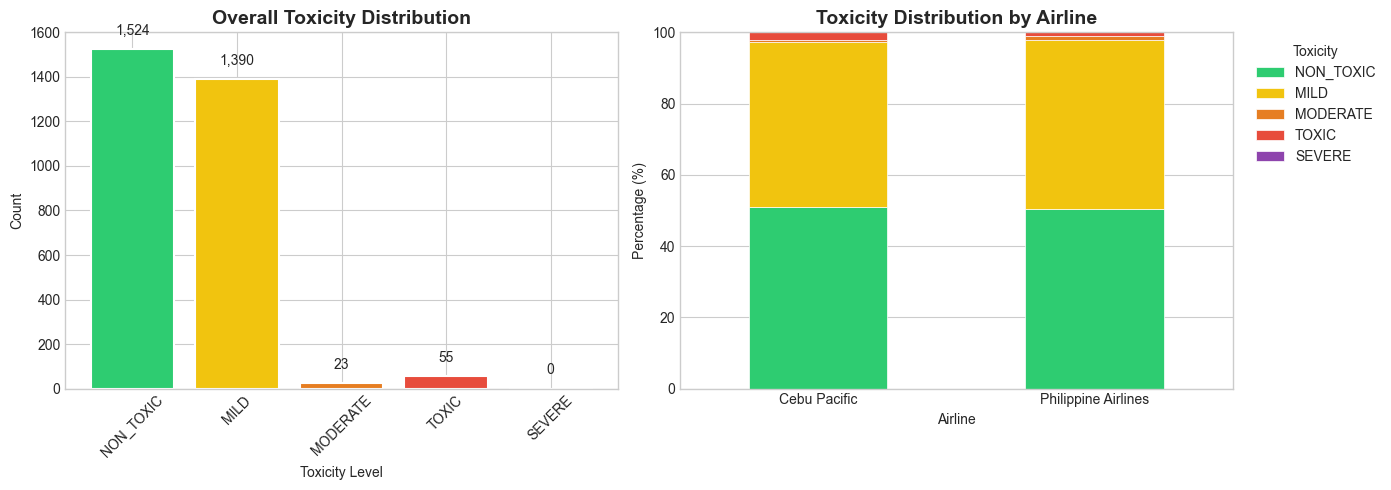


📊 Chart saved to: ./toxicity_results/toxicity_distribution.png


In [12]:
# ============================================================================
# VISUALIZATION: TOXICITY DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colors
colors = [ToxicityClassifier.LABEL_COLORS[l] for l in label_order]

# Plot 1: Overall Distribution
ax1 = axes[0]
counts = [toxicity_counts.get(l, 0) for l in label_order]
bars = ax1.bar(label_order, counts, color=colors, edgecolor='white', linewidth=1.5)
ax1.set_title("Overall Toxicity Distribution", fontsize=14, fontweight='bold')
ax1.set_xlabel("Toxicity Level")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

# Plot 2: By Airline (stacked percentage)
ax2 = axes[1]
crosstab_plot = crosstab.reindex(columns=label_order)
crosstab_plot.plot(kind='bar', stacked=True, ax=ax2, color=colors, edgecolor='white', linewidth=0.5)
ax2.set_title("Toxicity Distribution by Airline", fontsize=14, fontweight='bold')
ax2.set_xlabel("Airline")
ax2.set_ylabel("Percentage (%)")
ax2.tick_params(axis='x', rotation=0)
ax2.legend(title="Toxicity", bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "toxicity_distribution.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Chart saved to: {OUTPUT_DIR}/toxicity_distribution.png")

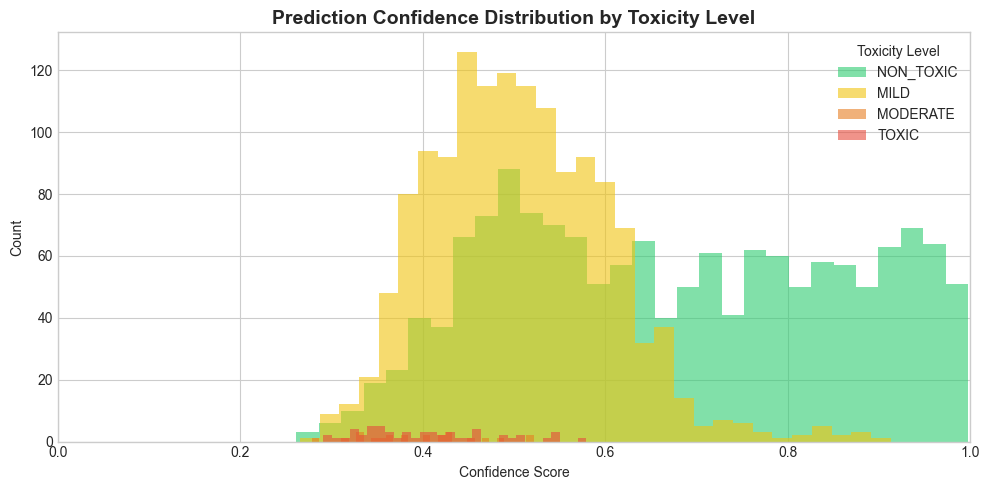

In [13]:
# ============================================================================
# VISUALIZATION: CONFIDENCE DISTRIBUTION
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 5))

for label in label_order:
    subset = df_results[df_results["toxicity_name"] == label]["toxicity_confidence"]
    if len(subset) > 0:
        ax.hist(subset, bins=30, alpha=0.6, label=label, 
                color=ToxicityClassifier.LABEL_COLORS[label])

ax.set_title("Prediction Confidence Distribution by Toxicity Level", fontsize=14, fontweight='bold')
ax.set_xlabel("Confidence Score")
ax.set_ylabel("Count")
ax.legend(title="Toxicity Level")
ax.set_xlim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confidence_distribution.png"), dpi=150, bbox_inches='tight')
plt.show()

<br>

---

## Step 9 — Example Predictions

View sample texts for each toxicity level.

In [14]:
# ============================================================================
# SAMPLE PREDICTIONS BY TOXICITY LEVEL
# ============================================================================

print(f"\n{'='*70}")
print("SAMPLE PREDICTIONS BY TOXICITY LEVEL")
print(f"{'='*70}")

for label in label_order:
    subset = df_results[df_results["toxicity_name"] == label]
    
    if len(subset) == 0:
        continue
    
    # Get top 3 highest confidence examples
    top_examples = subset.nlargest(3, "toxicity_confidence")
    
    print(f"\n{'─'*70}")
    print(f"📌 {label} (n={len(subset):,})")
    print(f"{'─'*70}")
    
    for idx, row in top_examples.iterrows():
        text = row["combined_text"][:150]
        conf = row["toxicity_confidence"]
        dataset = row["dataset"]
        print(f"\n[{dataset}] (conf: {conf:.1%})")
        print(f"   \"{text}...\"")


SAMPLE PREDICTIONS BY TOXICITY LEVEL

──────────────────────────────────────────────────────────────────────
📌 NON_TOXIC (n=1,524)
──────────────────────────────────────────────────────────────────────

[Cebu Pacific] (conf: 99.7%)
   "Cebu Pacific Flight Swap Offer Thank you sa libreng ₱5.3k, Cebu Pacific! I received an email about this flight swap offer earlier today. Wala namang m..."

[Cebu Pacific] (conf: 99.3%)
   "Hand Carry Luggage Size I have a flight to Cebu next week, and the dimension of the hand carry luggage I'm planning to bring is 53x35x25cm, 2cm more v..."

[Cebu Pacific] (conf: 99.3%)
   "Mag online check in kna po before flight para dirediretso na and screenshot lang ng boading pass mo na ang dadalhin mo plus valid ID. Sa baggage naman..."

──────────────────────────────────────────────────────────────────────
📌 MILD (n=1,390)
──────────────────────────────────────────────────────────────────────

[Philippine Airlines] (conf: 91.3%)
   "Manila is your port of entry,

<br>

---

## Step 10 — Export Results

In [15]:
# ============================================================================
# EXPORT RESULTS TO CSV
# ============================================================================

print(f"\n{'='*60}")
print("EXPORTING RESULTS")
print(f"{'='*60}")

# Export full results
full_output_path = os.path.join(OUTPUT_DIR, "toxicity_results_full.csv")
df_results.to_csv(full_output_path, index=False, encoding='utf-8-sig')
print(f"\n✅ Full results exported to: {full_output_path}")
print(f"   Rows: {len(df_results):,}")

# Export by dataset
for dataset_name in df_results["dataset"].unique():
    subset = df_results[df_results["dataset"] == dataset_name]
    filename = f"toxicity_results_{dataset_name.lower().replace(' ', '_')}.csv"
    output_path = os.path.join(OUTPUT_DIR, filename)
    subset.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ {dataset_name}: {output_path} ({len(subset):,} rows)")

# Export summary statistics
summary = df_results.groupby(["dataset", "toxicity_name"]).size().unstack(fill_value=0)
summary_path = os.path.join(OUTPUT_DIR, "toxicity_summary.csv")
summary.to_csv(summary_path)
print(f"✅ Summary statistics: {summary_path}")


EXPORTING RESULTS

✅ Full results exported to: ./toxicity_results\toxicity_results_full.csv
   Rows: 2,992
✅ Cebu Pacific: ./toxicity_results\toxicity_results_cebu_pacific.csv (2,285 rows)
✅ Philippine Airlines: ./toxicity_results\toxicity_results_philippine_airlines.csv (707 rows)
✅ Summary statistics: ./toxicity_results\toxicity_summary.csv


In [16]:
# ============================================================================
# EXPORT TOXIC CONTENT ONLY (FOR REVIEW)
# ============================================================================

# Filter for toxic content (MODERATE, TOXIC, SEVERE)
toxic_content = df_results[df_results["toxicity_name"].isin(["MODERATE", "TOXIC", "SEVERE"])]
toxic_content = toxic_content.sort_values("toxicity_label", ascending=False)

toxic_output_path = os.path.join(OUTPUT_DIR, "toxic_content_for_review.csv")
toxic_content.to_csv(toxic_output_path, index=False, encoding='utf-8-sig')

print(f"\n✅ Toxic content exported for review: {toxic_output_path}")
print(f"   Total toxic items: {len(toxic_content):,}")
print(f"   - MODERATE: {(toxic_content['toxicity_name'] == 'MODERATE').sum():,}")
print(f"   - TOXIC: {(toxic_content['toxicity_name'] == 'TOXIC').sum():,}")
print(f"   - SEVERE: {(toxic_content['toxicity_name'] == 'SEVERE').sum():,}")


✅ Toxic content exported for review: ./toxicity_results\toxic_content_for_review.csv
   Total toxic items: 78
   - MODERATE: 23
   - TOXIC: 55
   - SEVERE: 0


<br>

---

## Summary

In [17]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n{'='*70}")
print("📊 TOXICITY ANALYSIS SUMMARY")
print(f"{'='*70}")

print(f"\n📁 Datasets Analyzed:")
for dataset in df_results["dataset"].unique():
    count = (df_results["dataset"] == dataset).sum()
    print(f"   - {dataset}: {count:,} items")

print(f"\n📈 Overall Statistics:")
print(f"   - Total items analyzed: {len(df_results):,}")
print(f"   - Non-toxic rate: {(df_results['toxicity_name'] == 'NON_TOXIC').mean()*100:.1f}%")
print(f"   - High toxicity rate: {df_results['toxicity_name'].isin(['TOXIC', 'SEVERE']).mean()*100:.1f}%")
print(f"   - Average confidence: {df_results['toxicity_confidence'].mean():.1%}")

print(f"\n📂 Output Files:")
for f in os.listdir(OUTPUT_DIR):
    fpath = os.path.join(OUTPUT_DIR, f)
    size = os.path.getsize(fpath) / 1024
    print(f"   - {f} ({size:.1f} KB)")

print(f"\n{'='*70}")
print("✅ Analysis Complete!")
print(f"{'='*70}")


📊 TOXICITY ANALYSIS SUMMARY

📁 Datasets Analyzed:
   - Cebu Pacific: 2,285 items
   - Philippine Airlines: 707 items

📈 Overall Statistics:
   - Total items analyzed: 2,992
   - Non-toxic rate: 50.9%
   - High toxicity rate: 1.8%
   - Average confidence: 58.9%

📂 Output Files:
   - confidence_distribution.png (45.8 KB)
   - toxicity_distribution.png (87.8 KB)
   - toxicity_results_cebu_pacific.csv (1627.0 KB)
   - toxicity_results_full.csv (2248.4 KB)
   - toxicity_results_philippine_airlines.csv (621.7 KB)
   - toxicity_summary.csv (0.1 KB)
   - toxic_content_for_review.csv (46.2 KB)

✅ Analysis Complete!
